In [291]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
import torch
from torch import nn
from torch.utils.data import DataLoader,Dataset
from torch import optim
from torchvision import transforms,datasets
import pandas as pd
import torch.utils.data as Data
from sklearn import preprocessing
import imutils

%matplotlib inline

In [292]:
w = 128
h = 128
classes = 136

In [293]:
df_train = pd.read_csv("./training_frames_keypoints.csv")
df_test = pd.read_csv("./test_frames_keypoints.csv")

df_train.rename(columns = {"Unnamed: 0" : "Image_Name"},inplace=True)
df_test.rename(columns = {"Unnamed: 0" : "Image_Name"},inplace=True)

df_train.set_index("Image_Name",inplace = True)
df_test.set_index("Image_Name",inplace = True)

df_train.sort_index(inplace=True)
df_test.sort_index(inplace=True)

In [294]:
df_train.sort_index().head()

,0,1,2,3,4,5,6,7,8,9,...,126,127,128,129,130,131,132,133,134,135
Image_Name,,,,,,,,,,,,,,,,,,,,,
Abdel_Aziz_Al-Hakim_00.jpg,65.0,109.0,69.0,131.0,73.0,149.0,82.0,162.0,96.0,180.0,...,180.0,155.0,193.0,155.0,180.0,164.0,171.0,164.0,162.0,163.0
Abdel_Aziz_Al-Hakim_01.jpg,74.0,103.0,78.0,125.0,83.0,143.0,91.0,157.0,100.0,174.0,...,184.0,149.0,197.0,149.0,184.0,154.0,175.0,158.0,166.0,158.0
Abdel_Aziz_Al-Hakim_02.jpg,79.0,94.0,83.0,112.0,88.0,134.0,97.0,148.0,106.0,166.0,...,185.0,140.0,198.0,141.0,190.0,149.0,181.0,149.0,172.0,149.0
Abdel_Aziz_Al-Hakim_10.jpg,65.0,111.0,68.0,123.0,71.0,132.0,74.0,142.0,80.0,154.0,...,105.0,139.0,120.0,136.0,105.0,139.0,102.0,142.0,95.0,142.0
Abdel_Aziz_Al-Hakim_11.jpg,89.0,95.0,86.0,107.0,86.0,116.0,86.0,128.0,86.0,140.0,...,119.0,129.0,128.0,132.0,116.0,132.0,113.0,132.0,110.0,129.0


# Utility Function To Transform Landmark Points From Original Image Coords To Resized Image Coords

In [295]:
def transform_kps(kps,img):
    global w
    global h
    result = []
    
    target_w = img.shape[1]
    target_h = img.shape[0]
    
    ratio_w = w/target_w
    ratio_h = h/target_h
    
    for i in range(0,len(kps),2):
        pt = (int(kps[i]*ratio_w),int(kps[i+1]*ratio_h))
        result.append(pt[0])
        result.append(pt[1])
        
    return np.array(result,dtype = "int")

# Visualize An Image

In [296]:
img_name = "Ed_Smart_52.jpg"

img = cv2.imread(f"./training/{img_name}")
orig = img.copy()

kps = np.array(df_train.loc[img_name].values,dtype="int")
img_copy = img.copy()
for i in range(0,len(kps),2):
    pt = (kps[i],kps[i+1])
    cv2.circle(img_copy,pt,3,(255,0,255),-1)
    
cv2.imshow("Image",img_copy)
cv2.waitKey(0)
cv2.destroyAllWindows()

img = cv2.resize(img,(w,h))
kps = transform_kps(kps,orig)

for i in range(0,len(kps),2):
    pt = (kps[i],kps[i+1])
    cv2.circle(img,pt,3,(255,0,255),-1)
    
cv2.imshow("Image",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Transform And Scale Train/Test Labels

In [297]:
y_train = []
X_train = []

for row in df_train.iterrows():
    image_name = row[0]
    image_kps = row[1]
    img = cv2.imread(f"./training/{image_name}")
    kps = transform_kps(image_kps,img)
    y_train.append(kps)
    X_train.append(np.expand_dims(cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),(w,h))/255,0))
    
X_train = np.array(X_train)

In [298]:
y_test = []
X_test = []

for row in df_test.iterrows():
    image_name = row[0]
    image_kps = row[1]
    img = cv2.imread(f"./test/{image_name}")
    kps = transform_kps(image_kps,img)
    y_test.append(kps)
    X_test.append(np.expand_dims(cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),(w,h))/255,0))
    
X_test = np.array(X_test)

In [299]:
img_name = "Clark_Randt_22.jpg"

img = cv2.imread(f"./training/{img_name}")
img = cv2.resize(img,(w,h))

kps = y_train[788]

for i in range(0,len(kps),2):
    pt = (kps[i],kps[i+1])
    cv2.circle(img,pt,3,(255,0,255),-1)
    
cv2.imshow("Image",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [300]:
t = preprocessing.StandardScaler().fit(y_train)
y_train = t.transform(y_train)
y_test =  t.transform(y_test)

# Define Torch Loaders And Datasets

In [301]:
trans = transforms.Compose([transforms.ToTensor()])

X_train_tensor = torch.from_numpy(X_train).float()
X_test_tensor = torch.from_numpy(X_test).float()

y_train_tensor = torch.from_numpy(y_train).float()
y_test_tensor = torch.from_numpy(y_test).float()

In [302]:
X_train.shape

(3462, 1, 128, 128)

In [303]:
train_data = Data.TensorDataset(X_train_tensor,y_train_tensor)
test_data = Data.TensorDataset(X_test_tensor,y_test_tensor)

In [304]:
train_loader = DataLoader(train_data,batch_size=10,shuffle=True,num_workers=4)
test_loader = DataLoader(test_data,batch_size=128,shuffle=False)

In [305]:
images,labels = next(iter(train_loader))
kps =np.array(t.inverse_transform([labels[8].numpy()])[0],dtype="int")
img = images[8].numpy().squeeze()
    
for i in range(0,len(kps),2):
    pt = (kps[i],kps[i+1])
    cv2.circle(img,pt,3,(255,0,255),-1)
    
cv2.imshow("Image",img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# Creating The Model

In [306]:
model = nn.Sequential(
    nn.Conv2d(in_channels=1,out_channels=64,kernel_size=3), #OutDim = (128-3)/1  + 1 = (64,126,126)
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2,stride=2), #OutDim 126/2 = (64,63,63)
    nn.Dropout(0.2),
    
    nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3), #OutDim (64-3)/1+1 = (128,62,62),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2,stride=2), #OutDim 62/2 = (128,31,31)
    nn.Dropout(0.2),
    
    nn.Conv2d(in_channels=128,out_channels=256,kernel_size=3), #OutDim (31-3)/1+1 = (256,29,29),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2,stride=2), #OutDim 29/2 = (256,14,14)
    nn.Dropout(0.2),
   
    nn.Conv2d(in_channels=256,out_channels=512,kernel_size=3), #OutDim (14-3)/1+1 = (512,12,12),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 2,stride=2), #OutDim 12/2 = (512,6,6)
    nn.Dropout(0.3),
    
    nn.Flatten(),
    
    #nn.Linear(in_features=512*6*6,out_features=1024),
    #nn.ReLU(),
   # nn.Dropout(0.5),
    nn.Linear(in_features=512*6*6,out_features=classes)
)

# Training The Model

In [310]:
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

In [311]:
def test_error(model):
    steps = 0
    model.eval()
    running_loss = 0
    with torch.no_grad():
       
        for images,labels in iter(test_loader):
            steps+=1
            output = model.forward(images)
            MSE = criterion(labels,output).item()
            running_loss += MSE
    return running_loss/steps

In [316]:
epochs = 4
print_every = 1
steps = 0

for e in range(epochs):
    running_loss = 0
    for x,y in iter(train_loader):
        steps+= 1
        optimizer.zero_grad()
        output = model.forward(x)
        loss = criterion(output,y)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if steps % print_every == 0:
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every))
            
            running_loss = 0
            
    test_loss = test_error(model)
    print("Test Loss: " + str(test_loss))

Epoch: 1/4...  Loss: 0.2900
Epoch: 1/4...  Loss: 0.3252
Epoch: 1/4...  Loss: 0.3775
Epoch: 1/4...  Loss: 0.4395
Epoch: 1/4...  Loss: 0.3869
Epoch: 1/4...  Loss: 0.4002
Epoch: 1/4...  Loss: 0.2410
Epoch: 1/4...  Loss: 0.2369
Epoch: 1/4...  Loss: 0.3518
Epoch: 1/4...  Loss: 0.3278
Epoch: 1/4...  Loss: 0.3962
Epoch: 1/4...  Loss: 0.2906
Epoch: 1/4...  Loss: 0.3470
Epoch: 1/4...  Loss: 0.3211
Epoch: 1/4...  Loss: 0.3943
Epoch: 1/4...  Loss: 0.5475
Epoch: 1/4...  Loss: 0.2362
Epoch: 1/4...  Loss: 0.6370
Epoch: 1/4...  Loss: 0.3468
Epoch: 1/4...  Loss: 0.4057
Epoch: 1/4...  Loss: 0.2235
Epoch: 1/4...  Loss: 0.6004
Epoch: 1/4...  Loss: 0.2979
Epoch: 1/4...  Loss: 0.4006
Epoch: 1/4...  Loss: 0.4308
Epoch: 1/4...  Loss: 0.2969
Epoch: 1/4...  Loss: 0.2846
Epoch: 1/4...  Loss: 0.4980
Epoch: 1/4...  Loss: 0.2197
Epoch: 1/4...  Loss: 0.2248
Epoch: 1/4...  Loss: 0.4393
Epoch: 1/4...  Loss: 0.5802
Epoch: 1/4...  Loss: 1.4505
Epoch: 1/4...  Loss: 0.3955
Epoch: 1/4...  Loss: 0.3234
Epoch: 1/4...  Loss:

Epoch: 1/4...  Loss: 0.2826
Epoch: 1/4...  Loss: 0.3888
Epoch: 1/4...  Loss: 0.5534
Epoch: 1/4...  Loss: 0.2415
Epoch: 1/4...  Loss: 0.2873
Epoch: 1/4...  Loss: 0.4068
Epoch: 1/4...  Loss: 0.1947
Epoch: 1/4...  Loss: 0.3340
Epoch: 1/4...  Loss: 0.2191
Epoch: 1/4...  Loss: 0.2215
Epoch: 1/4...  Loss: 0.4321
Epoch: 1/4...  Loss: 0.2186
Epoch: 1/4...  Loss: 0.5588
Epoch: 1/4...  Loss: 0.1357
Epoch: 1/4...  Loss: 0.1823
Epoch: 1/4...  Loss: 0.2748
Epoch: 1/4...  Loss: 0.3780
Epoch: 1/4...  Loss: 0.4215
Epoch: 1/4...  Loss: 0.2201
Epoch: 1/4...  Loss: 0.3709
Epoch: 1/4...  Loss: 0.2363
Epoch: 1/4...  Loss: 0.6311
Epoch: 1/4...  Loss: 0.2344
Epoch: 1/4...  Loss: 0.2883
Epoch: 1/4...  Loss: 0.3667
Epoch: 1/4...  Loss: 0.5574
Epoch: 1/4...  Loss: 0.4448
Epoch: 1/4...  Loss: 0.6089
Epoch: 1/4...  Loss: 0.4028
Epoch: 1/4...  Loss: 0.3871
Epoch: 1/4...  Loss: 0.3186
Epoch: 1/4...  Loss: 0.7292
Epoch: 1/4...  Loss: 0.1730
Epoch: 1/4...  Loss: 0.1791
Epoch: 1/4...  Loss: 0.7137
Epoch: 1/4...  Loss:

Epoch: 2/4...  Loss: 0.2444
Epoch: 2/4...  Loss: 0.1356
Epoch: 2/4...  Loss: 0.3060
Epoch: 2/4...  Loss: 0.3781
Epoch: 2/4...  Loss: 0.2157
Epoch: 2/4...  Loss: 0.5081
Epoch: 2/4...  Loss: 0.1624
Epoch: 2/4...  Loss: 0.3024
Epoch: 2/4...  Loss: 0.2175
Epoch: 2/4...  Loss: 0.2621
Epoch: 2/4...  Loss: 0.2590
Epoch: 2/4...  Loss: 0.2228
Epoch: 2/4...  Loss: 0.1794
Epoch: 2/4...  Loss: 0.1300
Epoch: 2/4...  Loss: 0.3081
Epoch: 2/4...  Loss: 0.3726
Epoch: 2/4...  Loss: 0.3675
Epoch: 2/4...  Loss: 0.1430
Epoch: 2/4...  Loss: 0.3067
Epoch: 2/4...  Loss: 0.2088
Epoch: 2/4...  Loss: 0.2295
Epoch: 2/4...  Loss: 0.2309
Epoch: 2/4...  Loss: 0.3906
Epoch: 2/4...  Loss: 0.2504
Epoch: 2/4...  Loss: 0.1294
Epoch: 2/4...  Loss: 0.4740
Epoch: 2/4...  Loss: 0.1795
Epoch: 2/4...  Loss: 0.2468
Epoch: 2/4...  Loss: 0.4156
Epoch: 2/4...  Loss: 0.1683
Epoch: 2/4...  Loss: 0.2120
Epoch: 2/4...  Loss: 0.4724
Epoch: 2/4...  Loss: 0.3083
Epoch: 2/4...  Loss: 0.1889
Epoch: 2/4...  Loss: 0.2447
Epoch: 2/4...  Loss:

Epoch: 3/4...  Loss: 0.4018
Epoch: 3/4...  Loss: 0.3229
Epoch: 3/4...  Loss: 0.2647
Epoch: 3/4...  Loss: 0.1830
Epoch: 3/4...  Loss: 0.3284
Epoch: 3/4...  Loss: 0.2257
Epoch: 3/4...  Loss: 0.1626
Epoch: 3/4...  Loss: 0.3866
Epoch: 3/4...  Loss: 0.2914
Epoch: 3/4...  Loss: 0.3044
Epoch: 3/4...  Loss: 0.2116
Epoch: 3/4...  Loss: 0.1215
Epoch: 3/4...  Loss: 0.4901
Epoch: 3/4...  Loss: 0.1957
Epoch: 3/4...  Loss: 0.3111
Epoch: 3/4...  Loss: 0.1374
Epoch: 3/4...  Loss: 0.1414
Epoch: 3/4...  Loss: 0.2302
Epoch: 3/4...  Loss: 0.1839
Epoch: 3/4...  Loss: 0.1423
Epoch: 3/4...  Loss: 0.2248
Epoch: 3/4...  Loss: 0.2736
Epoch: 3/4...  Loss: 0.3412
Epoch: 3/4...  Loss: 0.5519
Epoch: 3/4...  Loss: 0.3546
Epoch: 3/4...  Loss: 0.2592
Epoch: 3/4...  Loss: 0.2825
Epoch: 3/4...  Loss: 0.4189
Epoch: 3/4...  Loss: 0.2592
Epoch: 3/4...  Loss: 0.5255
Epoch: 3/4...  Loss: 0.2379
Epoch: 3/4...  Loss: 0.2383
Epoch: 3/4...  Loss: 0.2474
Epoch: 3/4...  Loss: 0.2080
Epoch: 3/4...  Loss: 0.1060
Epoch: 3/4...  Loss:

Epoch: 4/4...  Loss: 0.1215
Epoch: 4/4...  Loss: 0.3670
Epoch: 4/4...  Loss: 0.1564
Epoch: 4/4...  Loss: 0.3692
Epoch: 4/4...  Loss: 0.1661
Epoch: 4/4...  Loss: 0.1825
Epoch: 4/4...  Loss: 0.1752
Epoch: 4/4...  Loss: 0.1679
Epoch: 4/4...  Loss: 0.1542
Epoch: 4/4...  Loss: 0.2180
Epoch: 4/4...  Loss: 0.1607
Epoch: 4/4...  Loss: 0.0921
Epoch: 4/4...  Loss: 0.1079
Epoch: 4/4...  Loss: 0.2724
Epoch: 4/4...  Loss: 0.1272
Epoch: 4/4...  Loss: 0.2025
Epoch: 4/4...  Loss: 0.1942
Epoch: 4/4...  Loss: 0.2822
Epoch: 4/4...  Loss: 0.3574
Epoch: 4/4...  Loss: 0.2047
Epoch: 4/4...  Loss: 0.1534
Epoch: 4/4...  Loss: 0.2929
Epoch: 4/4...  Loss: 0.1611
Epoch: 4/4...  Loss: 0.2158
Epoch: 4/4...  Loss: 0.1560
Epoch: 4/4...  Loss: 0.1483
Epoch: 4/4...  Loss: 0.1549
Epoch: 4/4...  Loss: 0.0840
Epoch: 4/4...  Loss: 0.1730
Epoch: 4/4...  Loss: 0.2117
Epoch: 4/4...  Loss: 0.1720
Epoch: 4/4...  Loss: 0.1869
Epoch: 4/4...  Loss: 0.0965
Epoch: 4/4...  Loss: 0.2306
Epoch: 4/4...  Loss: 0.2312
Epoch: 4/4...  Loss:

In [ ]:
test_loss = test_error(model)
print("Test Loss: " + str(test_loss))

In [320]:
torch.save(model.state_dict(),"model.model")

# Evaluating The Testing

[35.90127  69.06219  38.06698  73.746445 41.48095  78.30502  45.242134
 82.48315  49.87765  88.22093  54.85717  90.32824  58.446514 90.58625
 63.165104 90.78633  70.990295 89.81743  79.23658  85.71842  86.659584
 82.12278  91.95621  78.32429  94.25081  73.25954  95.0145   66.882996
 93.680595 61.92922  92.841125 55.859077 90.11965  50.15707  32.64296
 59.94552  33.205452 56.89917  36.034534 54.43508  39.078983 53.768456
 41.9799   53.219234 54.11042  48.43123  57.616997 46.699615 61.840485
 44.967262 67.19892  44.854263 73.0442   46.561234 50.795628 55.66809
 51.64021  58.88561  52.9725   62.32666  54.399204 64.905495 54.407673
 69.21455  55.382412 68.573296 57.98902  68.01986  60.25589  66.645645
 62.58668  66.223885 39.17958  61.981785 40.155136 60.42033  43.00946
 59.6186   46.95011  59.340137 44.27266  60.645622 41.631676 62.05815
 60.421333 54.786648 62.57698  53.443947 65.52226  52.43232  69.37598
 52.15926  66.857124 53.40382  63.44332  54.238594 55.6362   78.93145
 56.02156  75

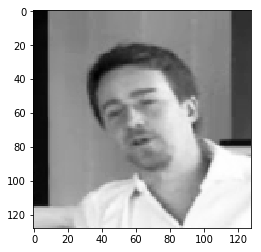

In [324]:
img = cv2.imread("./test/Edward_Norton_41.jpg")
img = cv2.resize(cv2.cvtColor(img,cv2.COLOR_BGR2GRAY),(w,h))/255
plt.imshow(img,cmap="Greys_r")

img_tensor = torch.tensor(np.expand_dims(np.expand_dims(img,0),0)).float()

model.eval()

with torch.no_grad():
    kps = t.inverse_transform(model.forward(img_tensor).numpy())[0]
    print(kps)
    
    for i in range(0,len(kps),2):
        pt = (kps[i],kps[i+1])
        cv2.circle(img,pt,1,(255,0,255),-1)
        
        
cv2.imshow("Image",imutils.resize(img,width = 500))
cv2.waitKey(0)
cv2.destroyAllWindows()